In [ ]:
!pip install pyspark networkx matplotlib pandas
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


In [ ]:
spark = SparkSession.builder.appName("SocialGraphAnalysis").getOrCreate()


In [ ]:
# Example if file is uploaded to Colab
call_data = spark.read.csv("call_data.csv", header=True, inferSchema=True)

# Inspect the data
call_data.show(5)
call_data.printSchema()


+---------+-----------+-------------------+--------+---------+
|caller_id|receiver_id|          timestamp|duration|call_type|
+---------+-----------+-------------------+--------+---------+
|     1012|       1014|2025-10-25 18:44:00|     210|      sms|
|     1021|       1031|2025-10-25 14:02:00|     446|    voice|
|     1045|       1019|2025-10-25 16:41:00|      96|      sms|
|     1018|       1047|2025-10-25 17:10:00|     411|    video|
|     1026|       1032|2025-10-25 18:17:00|      39|      sms|
+---------+-----------+-------------------+--------+---------+
only showing top 5 rows

root
 |-- caller_id: integer (nullable = true)
 |-- receiver_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- duration: integer (nullable = true)
 |-- call_type: string (nullable = true)



In [ ]:
 temporary view
call_data.createOrReplaceTempView("calls")
# Register
# Count total calls per user
spark.sql("""
    SELECT caller_id, COUNT(*) AS total_calls
    FROM calls
    GROUP BY caller_id
    ORDER BY total_calls DESC
    LIMIT 10
""").show()


SyntaxError: invalid syntax (ipython-input-2509823894.py, line 1)

In [ ]:
edges = call_data.select("caller_id", "receiver_id").toPandas()
G = nx.from_pandas_edgelist(edges, source="caller_id", target="receiver_id")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 50
Number of edges: 676


In [ ]:
# Degree Centrality — identify most connected users
centrality = nx.degree_centrality(G)
top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Influencers (Highest Centrality):")
for user, score in top_central:
    print(f"User {user} — Centrality: {score:.3f}")

# Average path length (if graph is connected)
if nx.is_connected(G):
    print("Average path length:", nx.average_shortest_path_length(G))
else:
    print("Graph is not fully connected.")


Top 5 Influencers (Highest Centrality):
User 1009 — Centrality: 0.653
User 1023 — Centrality: 0.653
User 1046 — Centrality: 0.653
User 1016 — Centrality: 0.653
User 1006 — Centrality: 0.633
Average path length: 1.4481632653061225


In [ ]:
from networkx.algorithms import community

communities = community.greedy_modularity_communities(G)
print(f"Detected {len(communities)} communities.")


Detected 2 communities.


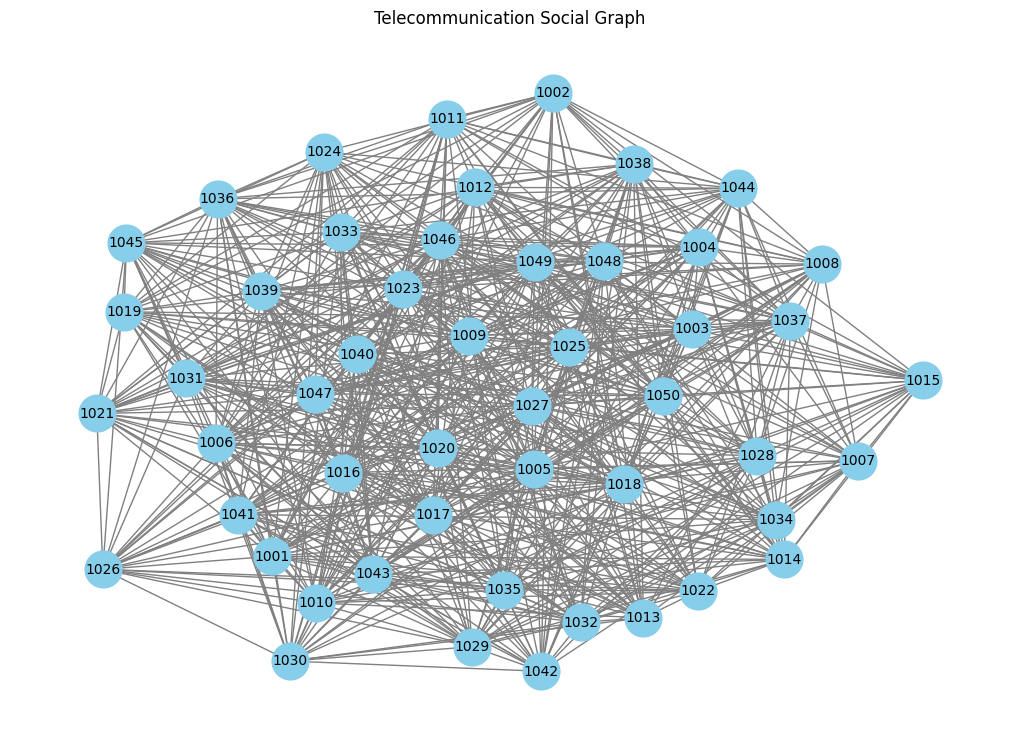

In [ ]:
plt.figure(figsize=(10,7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=700, font_size=10)
plt.title("Telecommunication Social Graph")
plt.show()


In [ ]:
edges_weighted = call_data.select("caller_id", "receiver_id", "duration").toPandas()
G_weighted = nx.from_pandas_edgelist(edges_weighted, source="caller_id", target="receiver_id", edge_attr="duration")

# Check total communication time per pair
for u, v, data in G_weighted.edges(data=True):
    print(u, "<->", v, "Duration:", data["duration"])


1012 <-> 1014 Duration: 210
1012 <-> 1040 Duration: 307
1012 <-> 1009 Duration: 477
1012 <-> 1011 Duration: 578
1012 <-> 1038 Duration: 589
1012 <-> 1041 Duration: 245
1012 <-> 1006 Duration: 273
1012 <-> 1044 Duration: 448
1012 <-> 1007 Duration: 17
1012 <-> 1049 Duration: 559
1012 <-> 1003 Duration: 574
1012 <-> 1022 Duration: 13
1012 <-> 1001 Duration: 178
1012 <-> 1008 Duration: 160
1012 <-> 1010 Duration: 365
1012 <-> 1017 Duration: 480
1012 <-> 1028 Duration: 218
1012 <-> 1048 Duration: 73
1012 <-> 1019 Duration: 274
1012 <-> 1023 Duration: 451
1012 <-> 1021 Duration: 479
1012 <-> 1031 Duration: 79
1012 <-> 1027 Duration: 439
1012 <-> 1015 Duration: 582
1012 <-> 1002 Duration: 593
1012 <-> 1034 Duration: 88
1012 <-> 1004 Duration: 372
1012 <-> 1005 Duration: 27
1012 <-> 1016 Duration: 331
1014 <-> 1024 Duration: 218
1014 <-> 1022 Duration: 312
1014 <-> 1004 Duration: 410
1014 <-> 1020 Duration: 189
1014 <-> 1039 Duration: 374
1014 <-> 1044 Duration: 545
1014 <-> 1003 Duration: 63

In [ ]:
print("=== SUMMARY OF SOCIAL GRAPH ANALYSIS ===\n")

# 1️⃣ Graph Overview
print(f"Total Users (Nodes): {G.number_of_nodes()}")
print(f"Total Connections (Edges): {G.number_of_edges()}")

# 2️⃣ Influencers
print("\nTop 5 Influencers (by Centrality):")
for user, score in top_central:
    print(f" - User {user} → Centrality Score: {score:.3f}")

# 3️⃣ Communities
print(f"\nDetected {len(communities)} communication communities.")

# 4️⃣ Example Observation
largest_comm = max(communities, key=len)
print(f"Largest Community Size: {len(largest_comm)} users")

print("\n✅ Analysis Completed Successfully!")


=== SUMMARY OF SOCIAL GRAPH ANALYSIS ===

Total Users (Nodes): 50
Total Connections (Edges): 676

Top 5 Influencers (by Centrality):
 - User 1009 → Centrality Score: 0.653
 - User 1023 → Centrality Score: 0.653
 - User 1046 → Centrality Score: 0.653
 - User 1016 → Centrality Score: 0.653
 - User 1006 → Centrality Score: 0.633

Detected 2 communication communities.
Largest Community Size: 28 users

✅ Analysis Completed Successfully!


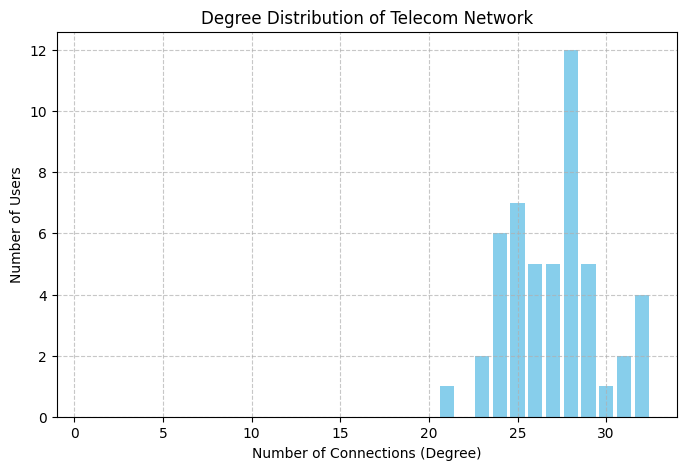

In [ ]:
#1️⃣ Degree Distribution Plot
import matplotlib.pyplot as plt

degrees = [deg for node, deg in G.degree()]
plt.figure(figsize=(8,5))
plt.hist(degrees, bins=range(1, max(degrees)+2), align='left', rwidth=0.8, color='skyblue')
plt.xlabel("Number of Connections (Degree)")
plt.ylabel("Number of Users")
plt.title("Degree Distribution of Telecom Network")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


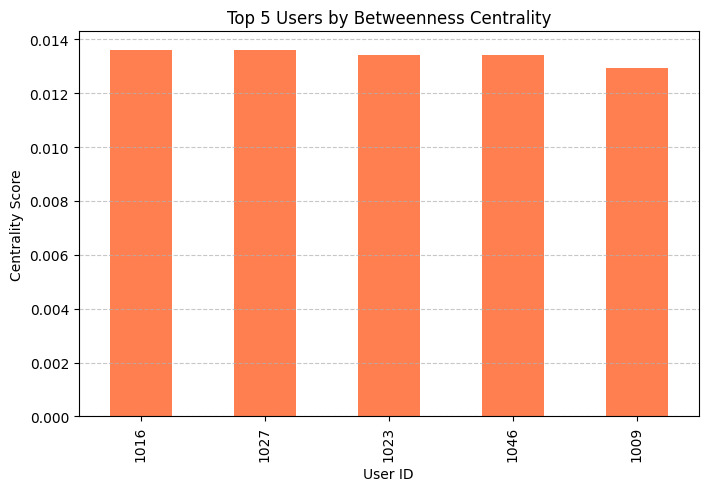

In [ ]:
#2️⃣ Network Centrality Comparison Bar Chart
# Betweenness centrality - measures "bridge" users connecting groups
betweenness = nx.betweenness_centrality(G)
top_between = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

# Convert to DataFrame for plotting
import pandas as pd
central_df = pd.DataFrame(top_between, columns=["User", "Betweenness"])
central_df.plot(x="User", y="Betweenness", kind="bar", color="coral", figsize=(8,5), legend=False)
plt.title("Top 5 Users by Betweenness Centrality")
plt.ylabel("Centrality Score")
plt.xlabel("User ID")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


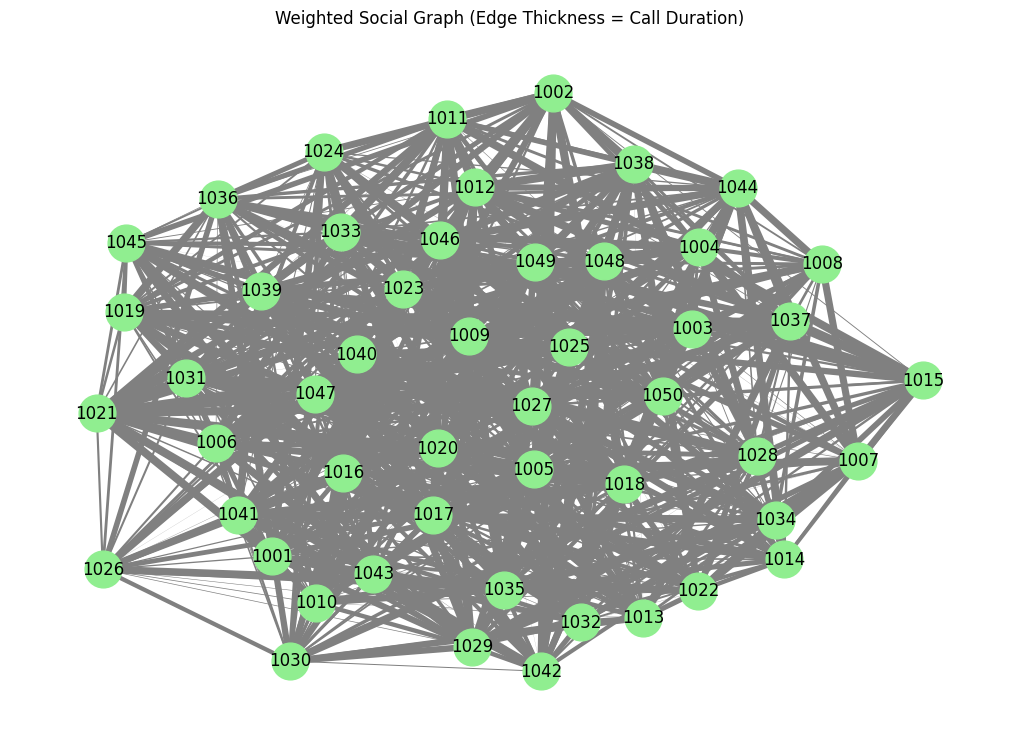

In [ ]:
#3️⃣ Weighted Network Visualization
# Create weighted graph
edges_weighted = call_data.select("caller_id", "receiver_id", "duration").toPandas()
G_weighted = nx.from_pandas_edgelist(edges_weighted, source="caller_id", target="receiver_id", edge_attr="duration")

# Draw weighted graph
plt.figure(figsize=(10,7))
pos = nx.spring_layout(G_weighted, seed=42)
weights = [d["duration"]/100 for _, _, d in G_weighted.edges(data=True)]  # scale duration for visualization
nx.draw(G_weighted, pos, with_labels=True, width=weights, node_color='lightgreen', edge_color='gray', node_size=700)
plt.title("Weighted Social Graph (Edge Thickness = Call Duration)")
plt.show()


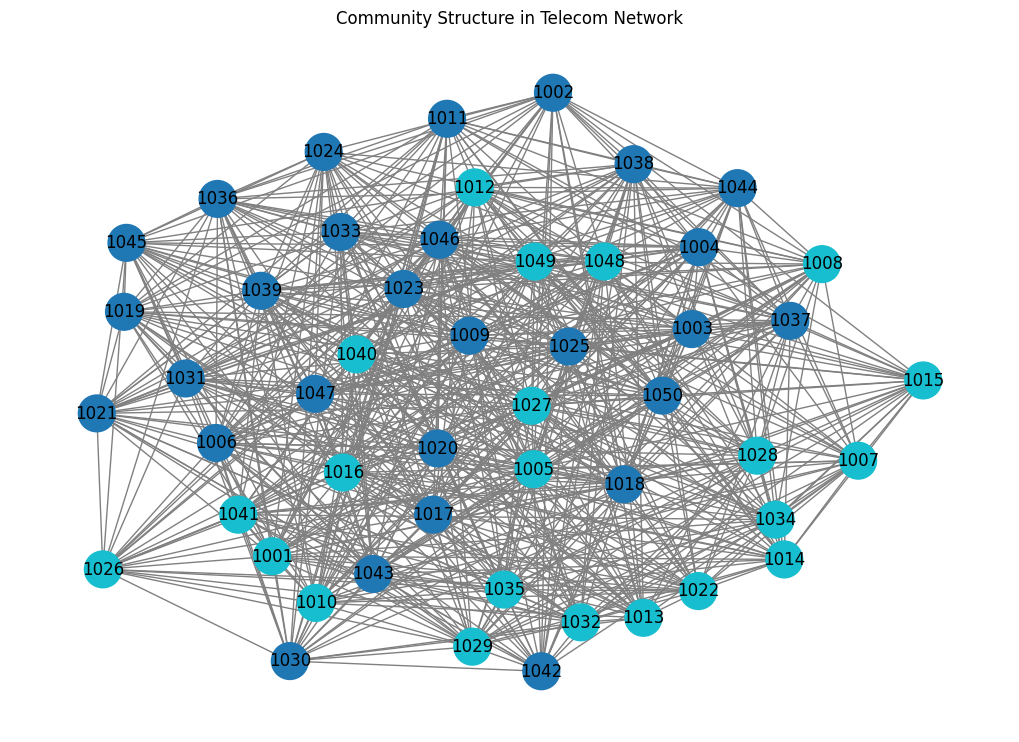

In [ ]:
#4️⃣ Community Structure Visualization
from networkx.algorithms import community
communities = list(community.greedy_modularity_communities(G))

# Assign a color to each community
color_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i

colors = [color_map[node] for node in G.nodes()]

plt.figure(figsize=(10,7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=colors, cmap=plt.cm.tab10, edge_color='gray', node_size=700)
plt.title("Community Structure in Telecom Network")
plt.show()


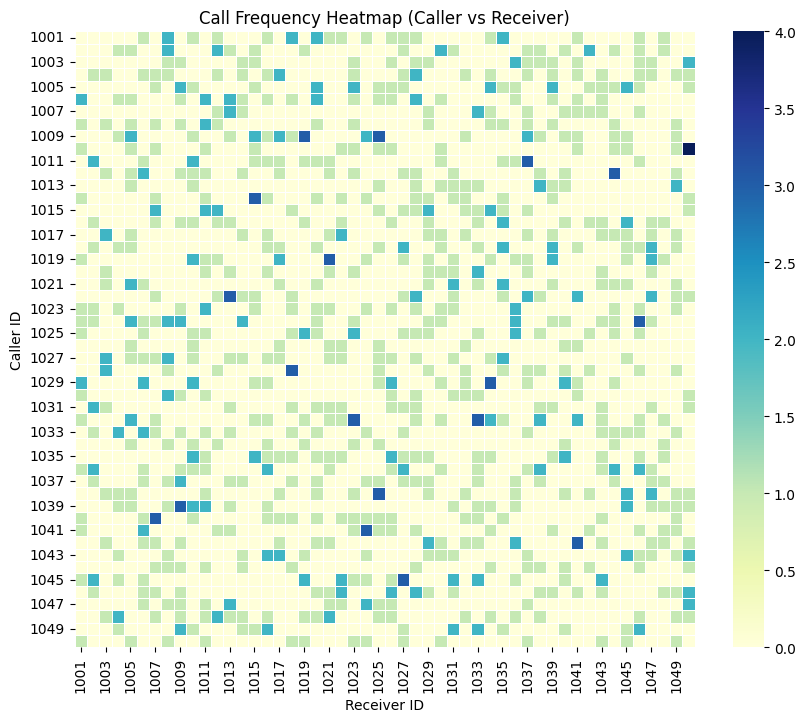

In [ ]:
#5️⃣ Call Frequency Heatmap (Optional Bonus Visualization)
import seaborn as sns

# Count total calls between each pair
pair_counts = call_data.groupBy("caller_id", "receiver_id").count().toPandas()
pivot = pair_counts.pivot(index="caller_id", columns="receiver_id", values="count").fillna(0)

plt.figure(figsize=(10,8))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.5)
plt.title("Call Frequency Heatmap (Caller vs Receiver)")
plt.xlabel("Receiver ID")
plt.ylabel("Caller ID")
plt.show()
